In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os

In [3]:
os.chdir("..")

In [4]:
import numpy as np
import scipy as sp
import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pickle
from tqdm import tqdm
from sampling.utils import SamplingLogger
import sys
sys.path.append('./sampling')

In [5]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [7]:
fold_idx = 2

In [8]:
with_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_with_sat.pkl", "rb"))
no_sat = pickle.load(open(f"results/fold_{fold_idx}/sampling_no_sat.pkl", "rb"))

In [9]:
df = pd.read_csv(f"results/fold_{fold_idx}/sampling_df.csv")

In [10]:
df_results = pd.read_csv("results/fold_%s/test_results.csv" % fold_idx)

In [11]:
print(df_results["state_name"][0], len(df_results))

Assam 23005


In [12]:
r2_score(df_results["true"], df_results["smoothed"])

0.10211553740190116

In [13]:
sp.stats.pearsonr(df["true"], df["electrification"])[0]

0.07206711556103013

In [156]:
# opt_r2 = max(
#   np.mean(np.array(random_sat.r2s_matrix)[:,-1]),
#   np.mean(np.array(random_nosat.r2s_matrix)[:,-1]),
# )

In [157]:
random_sat.arguments["batch_size"]

20

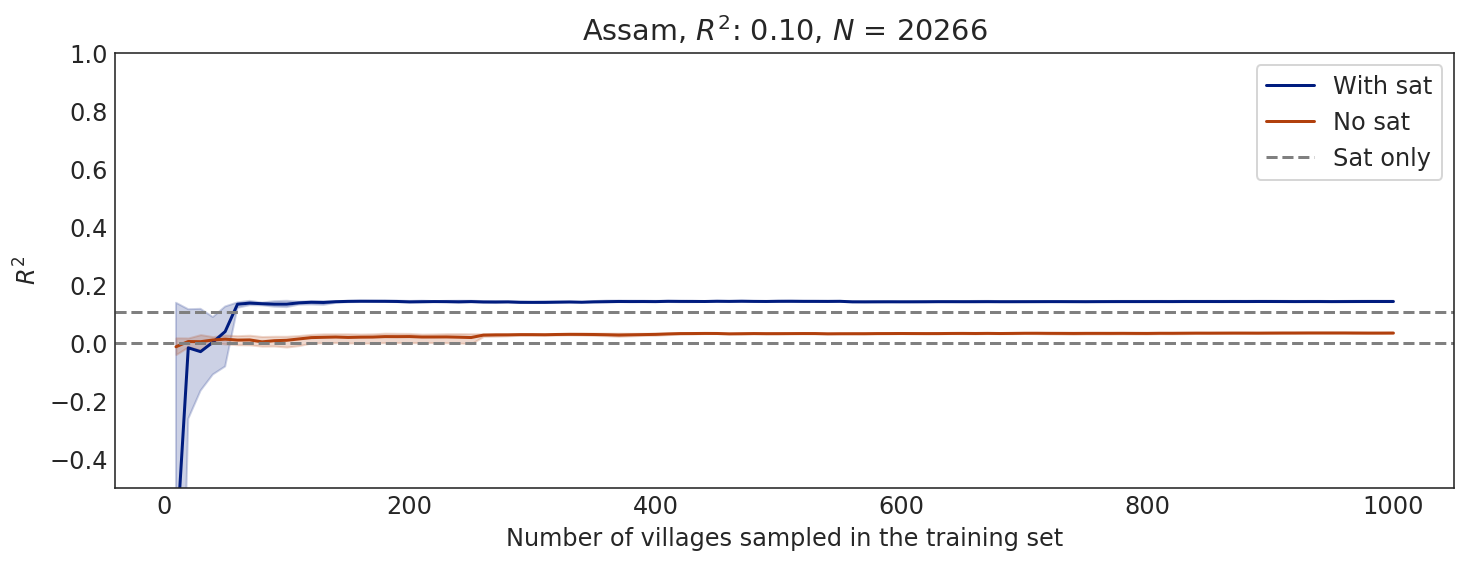

In [14]:
plt.figure(figsize=(12, 4))
sns.lineplot(x = "batch_no", y = "r2", label = "With sat", color = plt_colors[0],
             data = {"r2": with_sat.r2s, "batch_no": with_sat.batch_nos * with_sat.arguments["batch_size"]})
sns.lineplot(x = "batch_no", y = "r2", label = "No sat", color = plt_colors[1],
             data = {"r2": no_sat.r2s, "batch_no": no_sat.batch_nos * no_sat.arguments["batch_size"]})
plt.xlabel("Number of villages sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df["true"], df["pred"]), ls="--", color="grey", label="Sat only")
plt.axhline(0, ls="--", color="grey")
plt.ylim(-0.5, 1.0)
plt.title("%s, $R^2$: %.2f, $N$ = %d" % (df_results["state_name"][0], 
                                         r2_score(df_results["true"], df_results["smoothed"]),
                                         len(df)))
plt.legend();

In [ ]:
opt_coeff = pearsonr(df["electrification"], df["true"])[0]
sat_coeff = pearsonr(df["electrification"], df["pred"])[0]

In [ ]:
print(opt_coeff, sat_coeff)

In [ ]:
N = len(coeff_greedy.coeffs_matrix[0])

In [ ]:
se = np.sqrt(1 / (np.arange(N) - 3))

In [ ]:
se[np.arange(4)] = 1

In [56]:
plt.figure(figsize=(12, 4))
sns.tsplot(coeff_greedy.coeffs_matrix[0], condition="Greedy, samples only", color=plt_colors[2], ci=95)
sns.tsplot(coeff_greedy.coeffs_matrix[0] - 1.96 * se, condition="Greedy, samples only", color=plt_colors[2], ci=95)
sns.tsplot(coeff_greedy.coeffs_matrix[0] + 1.96 * se, condition="Greedy, samples only", color=plt_colors[2], ci=95)
# sns.tsplot(coeff_random.coeffs_matrix, condition="Random, samples only", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("Estimated $\\beta$")
plt.axhline(opt_coeff, ls="--", color="grey", label="True $\\beta$")
plt.axhline(sat_coeff, ls="--", color=plt_colors[4], label="Sat-only $\\beta$")
plt.ylim(-0.5, 1)
plt.title("%s, $R^2$: %.2f, $N$ = %d" % (df_results["state_name"][0], 
                                         r2_score(df_results["true"], df_results["smoothed"]),
                                         len(df_train) + len(df_val)))
plt.legend();

NameError: name 'coeff_greedy' is not defined

<Figure size 864x288 with 0 Axes>